## 1. Aims, objectives and plan (4 marks)

### a) Aims and objectives

The overarching objective is to provide an insurance company with a model that detects fraud cases, as per the case study provided. Given a set of historical csv datasets with various information about the claim, policy, demographics etc., the main requirement is to generate a model that can achieve a balanced error rate of 5%, using two different modelling techniques. As many of the provided features should be taken into account and appropriate metrics used. The final results must also be financially quantified to provide the client with an insight into how our model will affect their business.

## 2. Understanding the case study (4 marks)

###  Case study analysis

1. False positives (assuming fraudulent=positive) lead to complete loss of the customer, which should be minimised as much as possible.
2. False negatives on the other hand lead to the company paying out sums of money that the model could have flagged and thus avoided. This will again need to be minimised, as this is the main reason why such a model would be used over just paying all claims without any investigation.
3. The gain and loss from the above will need to be quantified by creating a pricing model, which would likely be the key determinant if the model is successful for the client. It remains to be seen whether the gain of not paying out fraudulent claims even offsets the potential loss of customers.
4. We are asked to obtain a balanced error (or 1-accuracy) below 5%, which uses recall (or detect) scores. This is a core requirement from the client and thus the main objective for our models in all techniques. It is also much more appropriate than simple accuracy given the imbalanced nature of fraud cases.
5. The requested error rate is very low, given the nature of the data. The models must generalise well to unseen cases and it remains to be seen if the very error rate required can be achieved after cross-validation and other measures to ensure generalisability are implemented.

## 3. Pre-processing applied (20 marks)

###  a) Importing libraries and merging datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Before anything else can be done, the datasets should first be merged into one dataframe that we can use.

In [2]:
# Vehicle dataset includes a problematic "VehicleAttribute" column that must be pivoted to avoid multiple entries per CustomerID
df_vehicle = pd.read_csv("Train_Vehicle.csv")
df_vehicle = df_vehicle.pivot_table(index="CustomerID", columns="VehicleAttribute", values="VehicleAttributeDetails", aggfunc="first")
df_vehicle.to_csv("Train_Vehicle_updated.csv")

files = ["Train_Claim.csv", "Train_Demographics.csv", "Train_Policy.csv", "Train_Vehicle_updated.csv"] # List of all non-target datasets
df = pd.read_csv("Traindata_with_Target.csv") # Dataset with targets and thus all CustomerIDs that we can use

# Now we can merge the files using the CustomerIDs that have a target ("ReportedFraud") attached to them
for file in files:
    df_temp = pd.read_csv(file)
    df = df.merge(df_temp, how="left", on="CustomerID")

df = df.set_index("CustomerID") # Use CustomerID as index
df.head()

,ReportedFraud,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,...,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleID,VehicleMake,VehicleModel,VehicleYOM
CustomerID,,,,,,,,,,,,,,,,,,,,,
Cust20065,N,2015-01-09,Multi-vehicle Collision,Rear Collision,Total Loss,Other,State9,City4,Location 1404,19,...,State2,250/500,2000,1142.87,0,own-child,Vehicle30662,Mercedes,E400,2005
Cust37589,N,2015-02-20,Single Vehicle Collision,Side Collision,Minor Damage,Ambulance,State4,City3,Location 1675,14,...,State2,100/300,1000,1274.38,2857344,own-child,Vehicle17183,Toyota,Highlander,2010
Cust24312,N,2015-01-14,Multi-vehicle Collision,Side Collision,Major Damage,Ambulance,State5,City2,Location 1546,21,...,State1,500/1000,745,1269.93,0,other-relative,Vehicle33982,Volkswagen,Passat,2002
Cust5493,Y,2015-01-07,Multi-vehicle Collision,Side Collision,Major Damage,Ambulance,State7,City4,Location 1413,12,...,State2,100/300,986,1218.60,0,other-relative,Vehicle12299,Toyota,Highlander,2011
Cust7704,Y,2015-02-26,Multi-vehicle Collision,Side Collision,Major Damage,Other,State4,City6,Location 1367,3,...,State3,250/500,576,1431.02,4235779,unmarried,Vehicle30447,Ford,Wrangler,2010


###  b) Removing synonymous and noisy attributes

With 40 independent columns, many of them are likely to not contribute to our model in any way, introducing unnecessary noise. Looking at the provided datasets, AttributeInformation file and quick checks in RapidMiner, the more obvious ones include:
- Country. Has only 1 unique value of "India"
- VehicleID: Unique for each row, so no need to have a second identifier.
- IncidentAddress: Provides way too much location detail that will not be usable by models.
- AmountOfTotalClaim: Is a sum of three other claim columns and as such will be used instead of those, as it avoids keeping three very correlated columns.
- InsuredZipCode: Another way too detailed location information.
- InsurancePolicyNumber: Another ID column unique for each record
- VehicleModel and VehicleYOM: Provide way too much detail about each vehicle.
- UmbrellaLimit: Noisy, uneven, includes negative values and with a large amount of values at 0.

Although many more columns might have very low informational value, as per instructions, let's try to use as many of the provided features as possible.

In [3]:
df = df.drop(columns=["Country","VehicleID","IncidentAddress","AmountOfInjuryClaim","AmountOfPropertyClaim","AmountOfVehicleDamage",
                      "InsuredZipCode","InsurancePolicyNumber","VehicleModel","VehicleYOM","UmbrellaLimit"])

###  c) Dealing with missing and duplicate values

In [4]:
# List of all labels for missing values as per the AttributeInformation PDF
missing_values = ["NA", "?", "???", "-1", "-5", "MISSINGVAL", "MISSEDDATA", "MISSINGVALUE"]
df.replace(missing_values, pd.NA, inplace=True) # Replace with pd.NA for now

# Check columns with missing values and their counts
miss = df.columns[df.isna().any()].tolist()
df[miss].isna().sum()

TypeOfCollission         5162
AuthoritiesContacted     2692
PropertyDamage          10459
Witnesses                  46
PoliceReport             9805
AmountOfTotalClaim         50
InsuredGender              30
VehicleMake                50
dtype: int64

Variables with almost 10000 missing values could be problematic, as this is more than a third of the data, so after quickly checking their low discriminative nature and given that we had 40 columns to begin with, I decided to remove these completely. TypeOfCollision's missing values can be treated as a separate, "Unknown" category, rather than removing them. The remaining columns have <51 missing datapoints, which I removed due to this being a tiny proportion of the data, where imputations would introduce unnecessary complexity. Some values previously included non-numeric entries for missing values, which should be rectified.

In [5]:
df = df.drop(columns=["PropertyDamage", "PoliceReport"])
df["TypeOfCollission"].fillna("Unknown", inplace=True)
df = df.dropna()
df["Witnesses"] = pd.to_numeric(df["Witnesses"])
df["AmountOfTotalClaim"] = pd.to_numeric(df["AmountOfTotalClaim"])

In [6]:
df.duplicated().sum() # Checking for any duplicate values

0

###  d) Appropriate feature selection or feature extraction

There are several columns that could be made more useful:
- DateOfIncident: Can be de-noised by using only day of week and month instead of full date, which has no bearing on whether fraud is committed.
- DateOfPolicyCoverage: Duration (in days) from commencement to incident could be more useful than exact commencement date.
- Policy_CombinedSingleLimit: Should be split into its two pieces of info - split limit and single limit.
- CapitalGains and Loss: Lots of 0 values and related columns were found. Summing them up mitigates this issue by combining into one Net column.

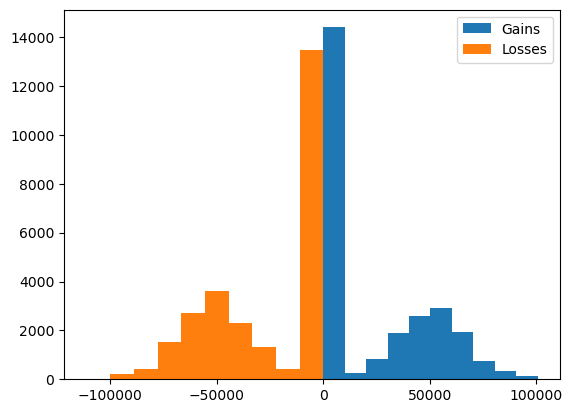

In [7]:
# Capital gains and losses before changes
a = plt.hist(df["CapitalGains"], bins=10, label="Gains")
b = plt.hist(df["CapitalLoss"], bins=10, label="Losses")
plt.legend();

In [8]:
# Creating all new features as described
df["DateOfIncident"] = pd.to_datetime(df["DateOfIncident"])
df["DateOfIncident_day"] = df["DateOfIncident"].dt.day_name()
df["DateOfIncident_month"] = df["DateOfIncident"].dt.month

df["DateOfPolicyCoverage"] = pd.to_datetime(df["DateOfPolicyCoverage"])
df["PolicyDuration"] = (df["DateOfIncident"] - df["DateOfPolicyCoverage"]).dt.days

df[['Split Limit', 'Single Limit']] = df['Policy_CombinedSingleLimit'].str.split('/', expand=True)

df["CapitalNet"] = df["CapitalGains"] + df["CapitalLoss"]
df.drop(columns=["DateOfIncident", "Policy_CombinedSingleLimit", "DateOfPolicyCoverage", "CapitalGains", "CapitalLoss"], inplace=True)

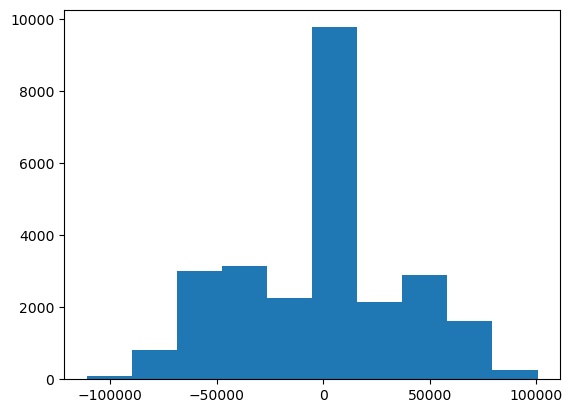

In [9]:
# New CapitalNet column
plt.hist(df["CapitalNet"], bins=10);

###  e) Dealing with collinearity

In [10]:
# Getting a dataframe with only correlations of >0.1
correl = df.corr(numeric_only=True)
correl = correl[abs(correl)>0.1]
correl = correl[abs(correl)<1].stack().reset_index()
correl.columns = ['Feature 1', 'Feature 2', 'Correlation']
correl

,Feature 1,Feature 2,Correlation
0,IncidentTime,NumberOfVehicles,0.126536
1,IncidentTime,AmountOfTotalClaim,0.185790
2,IncidentTime,InsuredAge,0.114721
3,NumberOfVehicles,IncidentTime,0.126536
4,NumberOfVehicles,AmountOfTotalClaim,0.171122
5,Witnesses,Policy_Deductible,0.103334
6,AmountOfTotalClaim,IncidentTime,0.185790
7,AmountOfTotalClaim,NumberOfVehicles,0.171122
8,InsuredAge,IncidentTime,0.114721
9,InsuredAge,CustomerLoyaltyPeriod,0.933326


CustomerLoyaltyPeriod is almost perfectly correlated with InsuredAge, so let's only keep age as the more standard attribute. The rest are not strongly correlated (<0.3).

In [11]:
df.drop(columns="CustomerLoyaltyPeriod", inplace=True)

###  f) Scaling and encoding variables

Categorical variables must be converted to machine-readable format by using encoders to convert categories to ordered values (for ordinal variables) or dummies (for categorical variables with no order). For a few variables, manual pre-processing is needed, as it allows for finer control over which values are ordinal and how they are ordered, while not leaking any data from for example imputations or scaling.

SeverityOfIncident is encoded as ordinal in a common sense order. However, Major Damage category was found to be the most discriminatory, so the resulting categories were 1-hot encoded, as the order itself was not providing information to the models.

In [12]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder, QuantileTransformer, KBinsDiscretizer
from sklearn.compose import ColumnTransformer

sev = OrdinalEncoder(categories=[['Trivial Damage', 'Minor Damage', 'Major Damage', 'Total Loss']])
df["SeverityOfIncident"] = sev.fit_transform(df[["SeverityOfIncident"]])

For Education, there are three doctoral levels that cannot be ranked above/below each other, so they are converted to one, and then encoded by level of education.

In [13]:
df["InsuredEducationLevel"].replace({'MD': 'Doctoral', 'PhD': 'Doctoral', 'JD' : 'Doctoral'}, inplace=True)
edu = OrdinalEncoder(categories=[['High School', 'College', 'Associate', 'Masters', 'Doctoral']])
df["InsuredEducationLevel"] = edu.fit_transform(df[["InsuredEducationLevel"]])

Finally, the labels are encoded, as the pipeline in the pre-processing stage cannot look at the labeled data to prevent any possible leakage. Binary encoding by itself does not risk leakage.

In [14]:
lab = LabelEncoder()
df['ReportedFraud'] = lab.fit_transform(df['ReportedFraud'])

The remaining columns can be encoded via a pipeline, as they do not require a manual ordering and re-labeling of values and could result in leakage when scaling and other transformations are done. Policy Deductible, AnnualPremium and AmountOfTotalClaim exhibited very uneven or non-standard distributions. Deductible is discretised to three bins, while Premium and Total Claim are transformed via the QuantileEncoder, which was found to work well for the skewed normal distributions.

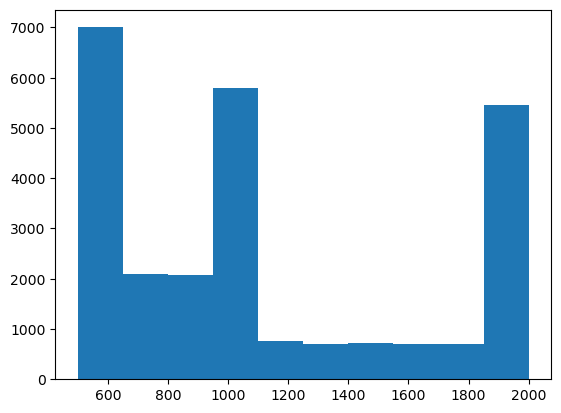

In [15]:
plt.hist(df["Policy_Deductible"]);

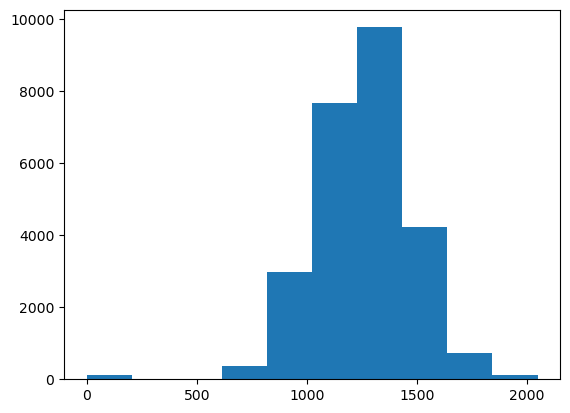

In [16]:
plt.hist(df['PolicyAnnualPremium']);

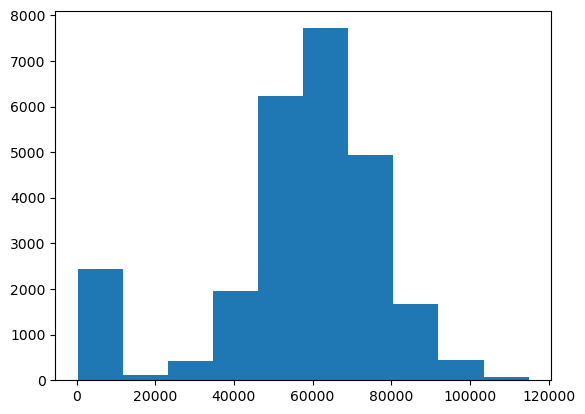

In [17]:
plt.hist(df["AmountOfTotalClaim"]);

The remaining columns can be converted to dummy variables, or simply scaled, using basic sklearn functions. Finally, a pre-processor is made for the pipelines, using a list of columns to encode in these specified ways. Note that some columns can appear more times, being scaled even after for example an ordinal transformation, to prevent feature dominance.

In [18]:
# List of columns per type
bin = ["Policy_Deductible"]
skew = ["AmountOfTotalClaim", 'PolicyAnnualPremium']
numeric = ['IncidentTime', 'AmountOfTotalClaim', 'InsuredAge', 'CapitalNet', 'Policy_Deductible', 'PolicyAnnualPremium',
        'PolicyDuration', "NumberOfVehicles", 'BodilyInjuries', 'Witnesses', 'Split Limit', 'Single Limit', "InsuredEducationLevel"]
dummy = ["TypeOfIncident", "AuthoritiesContacted", "IncidentState", "InsurancePolicyState", "InsuredRelationship", "SeverityOfIncident", "VehicleMake",
         "InsuredGender", "InsuredOccupation", "InsuredHobbies", "DateOfIncident_day", 'DateOfIncident_month', "IncidentCity","TypeOfCollission"]

In [19]:
preprocessor = ColumnTransformer(transformers=[
        ('bin', KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform'), bin),
        ('skew', QuantileTransformer(output_distribution='normal'), skew),
        ('numeric', StandardScaler(), numeric),
        ('dummy', OneHotEncoder(), dummy)])

###  g) Dealing with class imbalance

Fraud: 7487 
Not Fraud: 18544 
% of fraud: 0.288


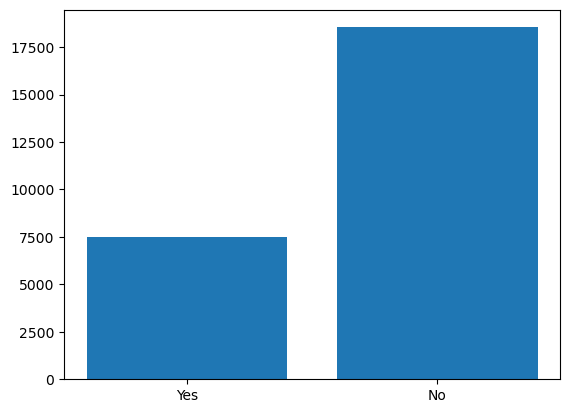

In [20]:
# Counting and plotting Fraud/Non-Fraud cases on the cleaned dataset
fraud = df[df["ReportedFraud"]==1].shape[0]
not_fraud = df[df["ReportedFraud"]==0].shape[0]
print("Fraud:",fraud, "\nNot Fraud:", not_fraud, "\n% of fraud:", round(fraud/(not_fraud+fraud),3))
plt.bar(["Yes", "No"], [fraud, not_fraud]);

There is indeed a large discrepancy between fraudulent and non-fraudulent claims, as could be expected in such data. There are several techniques to deal with such an imbalance:
- Appropriate performance measure: As mentioned in the case study as well, we should use balanced accuracy (average of recalls) instead of any non-hollistic measures, which might favor one class over another.
- Appropriate models: Models that better handle imbalances could be preferred, or adjusted to be able to deal with it.
- Resampling: Over/undersampling could be implemented to get a balanced proportion of classes.

The subsequent analyses will use the first two techniques to tackle the issue of class imbalance. Balanced accuracy scores will be used and models will be chosen and/or adjusted for handling class imbalances. Oversampling or undersampling of data would result in either creating synthetic data, or removing large portions of the data, and will be avoided unless the models prove to struggle with class imbalance even after adjustments.

## 4. Technique 1 (20 marks)

### a) Discuss your motivation for choosing the technique and provide a schematic figure of the process

The first technique of choice is the k-nearest neighbours algorithm. It is a fairly simple technique with a fast implementation, allowing for a good benchmark for subsequent analyses. It is a lazy classifier, skipping a standard training phase and simply making predictions as needed. Despite being simple, it can produce decision boundaries of abitrary shapes and is thus relevant even with such complex datasets as the one provided. Moreover, it has ways of dealing with class imbalance, as long as there are differences between the fraudulent and non-fraudulent cases. It is however susceptible to feature dominance and missing values, which have to fixed before creating a final model.

A schematic figure of the process of kNN is shown below:

<img src="knn.png" alt="kNN" style="width: 650px;"/>

### b) Setting hyper parameters with rationale

The most important hyperparameter for kNN is the number of neighbours, deciding how many of the closest points to weigh. The weighing itself is also hugely important, as well as the distance metric used to calculate similarity. While many other hyperparameters and their values could be chosen, the initial grid search values were chosen as per the explanation above and below, as well as to keep computing time reasonable.
- Number of neighbours: To be found via a grid search. Some experimentation was done using the elbow method to select the initial values, which cannot be too small to prevent overfitting, and too large to avoid the majority class to start having too much weight. 6, 8 and 10 were selected as the most promising candidates.
- Weights: Distance-based voting will be used to tackle class imbalance.
- Metric: Two standard metrics: euclidean and manhattan will be tested in grid search.

In [21]:
param_grid_knn = {'clas__n_neighbors': [6, 8, 10], # Necessary to include classifier name__ when using pipelines 
    'clas__weights': ['distance'],
    'clas__metric': ['euclidean', 'manhattan']}

### c) Optimising hyper parameters


First, import all sklearn libraries that will be used.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

Next, prepare our dataset and labels and do a train/test split. This needs to be stratified to account for the target class imbalance. The testing set will be left completely unseen and only used for final performance testing in following sections, so as to avoid any potential data leakage. The test size is kept at 20%, as our dataset is fairly large and it is better to have lots of training values, especially for kNN.

In [23]:
X = df.iloc[:,1:]
y = df["ReportedFraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

Finally, the hyperparameters can start being optimised, using a Grid Search.

In [24]:
# Prepare pipeline of preprocessing and classification
knn = KNeighborsClassifier()
pipe_knn = Pipeline([("prep", preprocessor), ("clas", knn)])

scoring = make_scorer(balanced_accuracy_score) # Use balanced accuracy throughout

In [25]:
# Prepare score holders
non_nested_scores = 0
nested_scores = 0

The process uses an inner cross-validation procedure to obtain optimal hyperparameters, and an outer cross-validation to evaluate the models' generalisation ability, still using only the training data. It uses a stratified split (5 and 4 folds to perform rigorous CV, but avoid too much computational intensity) and balanced accuracy scoring to account for the class imbalance.

In [26]:
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=1) 

search_knn = GridSearchCV(pipe_knn, param_grid=param_grid_knn, cv=inner_cv, scoring=scoring)
search_knn.fit(X_train, y_train)
non_nested_scores = search_knn.best_score_

nested_score = cross_val_score(search_knn, X=X_train, y=y_train, cv=outer_cv, scoring=scoring)
nested_scores = nested_score.mean()

In [27]:
search_knn.best_params_

{'clas__metric': 'manhattan',
 'clas__n_neighbors': 10,
 'clas__weights': 'distance'}

### d) Performance metrics for training

In [28]:
print(nested_scores, non_nested_scores)

0.9150107993214226 0.9154277492104475


The nested cross-validation ensures that our model finds optimal hyperparameters, but also generalises well to unseen data, using its own folds to do training and testing on different parts of the training dataset multiple times. The final nested score is 91.50% and non-nested is 91.54%, showing the expected slight drop in balanced accuracy when nested CV is performed over non-nested CV.

We can compare this with the results of fitting a model without using any CV, just fitting the kNN using the optimal hyperparameters found previously and checking its accuracy on the training set.

In [29]:
knn_nocv = search_knn.best_estimator_
knn_nocv.fit(X_train, y_train)

y_pred = knn_nocv.predict(X_train)
acc = balanced_accuracy_score(y_train, y_pred)
print(acc)

1.0


The training accuracy for a kNN without any CV is not very useful as it is a lazy classifier where the "fit" function simply stores the training datapoints - i.e. there is no training phase. Calculating distance from datapoints that are already in the dataset will almost always return 100% accuracy, especially with distance-based voting. However, the cross-validation process gives us confidence that it is indeed the best possible model to use even for unseen data.

We can plot the final results of balanced accuracies for nested CV, non-nested CV and no CV processes:

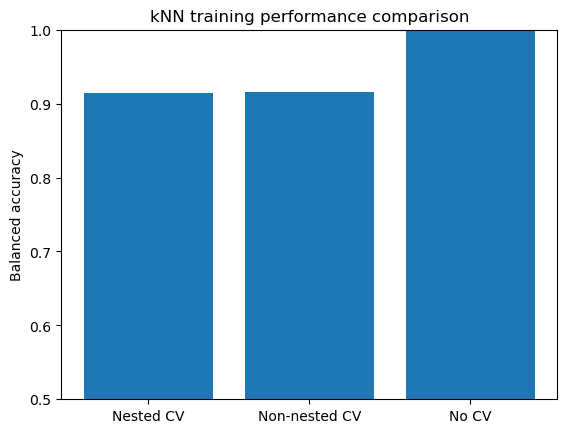

In [30]:
models = ["Nested CV", "Non-nested CV", "No CV"]
scores = [nested_scores, non_nested_scores, acc]
plt.bar(models, scores)
plt.ylim(0.5, 1.0)
plt.ylabel('Balanced accuracy')
plt.title('kNN training performance comparison');

## 5. Technique 2 (20 marks)

### a) Discuss your motivation for choosing the technique and  provide a schematic figure of the process

The second technique is a random forest classifier. Random forests are good at handling imbalanced datasets and can also identify relevant features, which might be helpful with the amount of variables provided. It works well against overfitting and contrasts well with kNN, as it has a standard training phase where it learns patterns in the data which are represented as an ensemble of decision trees, which simply linearly separate the provided data based on a subset of variables to achieve the highest purity. The choice of random samples and features should also prevent overfitting well. It is however a bit more challenging to fine-tune and more computationally expensive to train.

A schematic figure of the process of Random Forest is shown below:

<img src="rf.png" alt="kNN" style="width: 800px;"/>

### b) Setting hyper parameters with rationale

The most important parameter for a random forest is the number of decision trees, or estimators that are created. The way these decision trees are created using different criteria is also considered below.
- Estimators: The final number will be found via a grid search, using potential candidates found using initial experimentation. Values are kept reasonable to avoid long training times and overfitting.
- Criterion: Will use the default Gini coefficient to determine the quality of a split.
- Max depth: A value of 20 is used to prevent extremely large trees and overfitting.
- Weight: Class weight will be "balanced" to account for the class imbalance by weighing inversely proportional to frequency.
- Max features: The number of features to choose for determining splits for each tree will be kept at the default and standard square root of all features.
- Min samples split: This value can be increased to control the size of trees by limiting when they can still split. Two values will be tested to try and see if it helps with overfitting.

In [31]:
param_grid_rf = {'clas__n_estimators': [100, 200],
    'clas__min_samples_split': [4, 6],
    'clas__max_depth': [20],
    'clas__class_weight': ['balanced']}

### c) Optimising hyper parameters


In [32]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
pipe_rf = Pipeline([("prep", preprocessor), ("clas", rf)])

We will use the same training set, test set and prepared methods as for kNN to ensure fairness and consistency.

In [33]:
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=2)

search_rf = GridSearchCV(pipe_rf, param_grid=param_grid_rf, cv=inner_cv, scoring=scoring)
search_rf.fit(X_train, y_train)
non_nested_scores = search_rf.best_score_

nested_score = cross_val_score(search_rf, X=X_train, y=y_train, cv=outer_cv, scoring=scoring)
nested_scores = nested_score.mean()

In [34]:
search_rf.best_params_

{'clas__class_weight': 'balanced',
 'clas__max_depth': 20,
 'clas__min_samples_split': 4,
 'clas__n_estimators': 200}

### d) Performance metrics for training

In [35]:
print(nested_scores, non_nested_scores)

0.8713098949739075 0.8742721073857866


The final result of the nested CV is 87.13% and non-nested is 87.43%.

We can once again compare this with no CV scores.

In [36]:
rf_nocv = search_rf.best_estimator_
rf_nocv.fit(X_train, y_train)

y_pred = rf_nocv.predict(X_train)
acc = balanced_accuracy_score(y_train, y_pred)
print(acc)

0.9656542499582005


The training performance without any CV is much higher at 96.57%, despite using the same hyperparameters and process. This shows why it is necessary to perform at least some kind of cross-validation to get much more representative measures of performance. Despite the model seemingly overfitting when used on the entire training data, it still comes up as the top model to use from the cross-validation.

Finally, we can plot all the results.

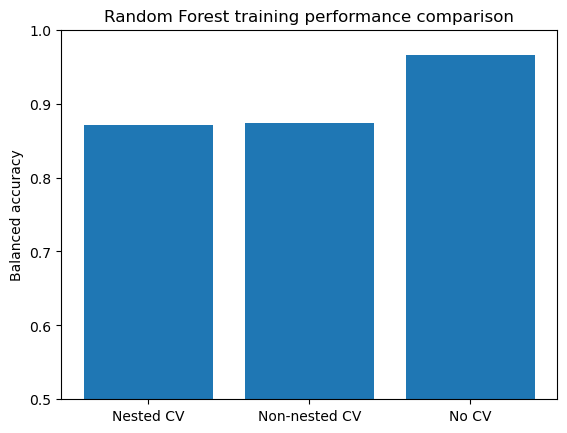

In [37]:
models = ["Nested CV", "Non-nested CV", "No CV"]
scores = [nested_scores, non_nested_scores, acc]
plt.bar(models, scores)
plt.ylim(0.5, 1.0)
plt.ylabel('Balanced accuracy')
plt.title('Random Forest training performance comparison');

## 6. Comparison of metrics performance for testing (16 marks)

### a) Use of cross validation for both techniques to deal with over-fitting

Cross-validation was implemented in two ways - nested and non-nested - for the selection of hyperparameters and evaluation of generalisation ability of each model. This was done separately in the previous sections, as it made sense to compare among them for each technique rather than return to this analysis later. The results were also compared with a direct fitting on the entire testing set for each model, which led to much too optimistic final accuracies for both models. The subsequent section will reveal whether the nested CV results are indeed representative of the final testing performance.

### b) Comparison with appropriate metrics for testing

Despite the cross-validation, this was still all done on the training data and the final average of the balanced accuracies from the nested CV is still not guaranteed to be an unbiased measure of performance. We will thus measure performance of the final best model for each technique on the completely unseen testing data.

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score

def Metrics(technique):
    final = technique.best_estimator_
    y_pred = final.predict(X_test)
    print("Balanced accuracy & error: ", round(balanced_accuracy_score(y_test, y_pred)*100, 2), round((1-balanced_accuracy_score(y_test, y_pred))*100, 2))
    print("F1 score: ", round(f1_score(y_test, y_pred)*100, 2))
    print("Detect fraud: ", round(recall_score(y_test, y_pred)*100, 2))
    print("Detect not-fraud: ", round(recall_score(y_test, y_pred, pos_label=0)*100, 2))
    print("Predict fraud: ", round(precision_score(y_test, y_pred)*100, 2))
    print("Predict not-fraud: ", round(precision_score(y_test, y_pred, pos_label=0)*100, 2))
    cm = confusion_matrix(y_test, y_pred, labels=technique.classes_, normalize='all') # Normalise over everything, to see distribution
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=technique.classes_)
    disp.plot()
    plt.show()

Balanced accuracy & error:  91.13 8.87
F1 score:  89.14
Detect fraud:  84.11
Detect not-fraud:  98.14
Predict fraud:  94.81
Predict not-fraud:  93.86


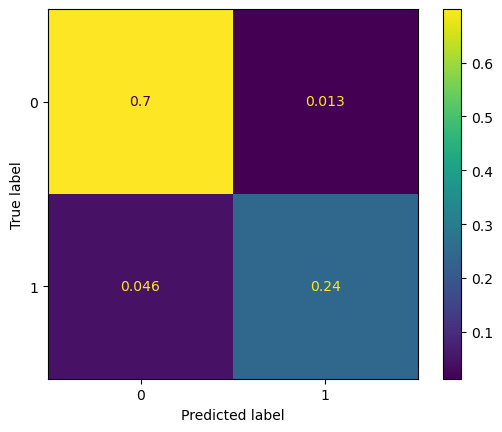

In [49]:
Metrics(search_knn)

Balanced accuracy & error:  87.47 12.53
F1 score:  83.82
Detect fraud:  78.5
Detect not-fraud:  96.44
Predict fraud:  89.91
Predict not-fraud:  91.74


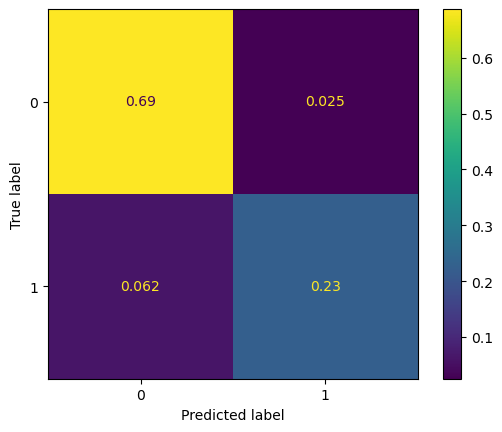

In [50]:
Metrics(search_rf)

Indeed the nested CV performance was the most indicative of final testing performance of each model. The final results show that kNN has a greater overall accuracy as well as all the other individual measures reported, whether holistic or not. Particularly, it excels in minimising incorrectly predicted fraud cases, which is important given that getting this wrong results in losing a customer.

### c) Model selection (ROC or other charts)

According to Tan et al. (2020), the precision-recall (PR) curve is "more suited for evaluating classification performance in the presence of class imbalance" and thus used for our model selection. It is visualised below:

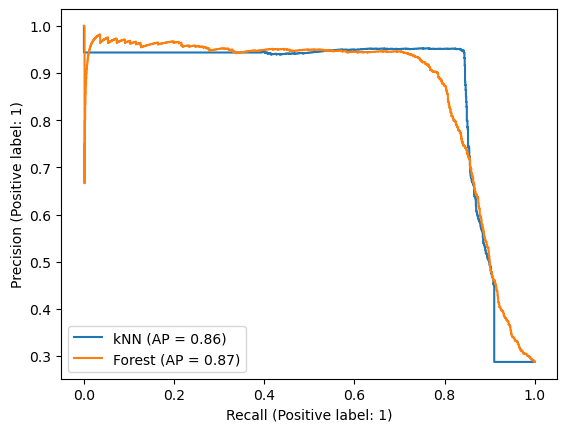

In [41]:
from sklearn.metrics import PrecisionRecallDisplay, auc

display_knn = PrecisionRecallDisplay.from_estimator(search_knn.best_estimator_, X_test, y_test, name="kNN", ax=plt.gca())
display_rf = PrecisionRecallDisplay.from_estimator(search_rf.best_estimator_, X_test, y_test, name="Forest", ax=plt.gca())

## 7. Final Recommendation of Best Model (8 marks)

### a) Discuss the results from a technical perspective, for example, overfitting discussion, complexity and efficiency

The precision-recall curves are summarised by the average precision (AP) score. This is calculated as a weighted sum of precisions at every threshold, weighing by the increase in recall, providing a very robust performance indicator. Although the random forest has a slightly higher AP score, this is not a perfect guarantee of a better model. The curves perform differently for different thresholds and with the tiny difference in score, it is not possible to say that one model overperforms the other. However, the kNN has a much better balanced accuracy, f1 score and all other related metrics on the final test which set are all a sign of it being the more suitable model of the two for the problem at hand.

Through hyperparameter selection, the kNN minimised overfitting and performed similarly for the training (with CV) and testing sets, achieving a final balanced accuracy score of 91.1% (error of 8.9%). This is more than the desired error of 5% or less, but a business analysis of the achieved error must also be taken into account (debated in following section). The model is fairly easy to understand and fast to implement, and adjustments to it can be made by simply adding new datapoints without having to retrain the model. It is however slightly more computationally expensive to predict new data than with a traditional trained model, especially if the dataset significantly increases in size in the future.

### b) Discuss the results from a business perspective, for example, results interpretation, relevance and balance with technical perspective

To get an insight into how the model will affect business. a pricing model is needed.

In [42]:
claims = pd.read_csv("Train_Claim.csv")
claims.replace(missing_values, pd.NA, inplace=True)
claims["AmountOfTotalClaim"] = pd.to_numeric(claims["AmountOfTotalClaim"])

mean_claim = claims["AmountOfTotalClaim"].mean()
mean_claim

52308.54547349406

The total amount of claims in the customer base is 10%. We are only given data for three months and the time scale is not specified, so let's use 4x that value as a measure of total customers in a year.

In [43]:
given_claims = claims["AmountOfTotalClaim"].size
no_customers = given_claims*10*4
no_customers

1153440

In a year then, 10% of the customers will have a claim and we can use the calculated average for its amount (in Indian rupees). The yearly gross profit must be double this amount and the company should thus charge this amount divided into its customer base.

In [44]:
total_claim = (no_customers*0.1)*mean_claim
gross_profit = 2*total_claim
charge = gross_profit/no_customers
print(total_claim)
print(charge)

6033476869.094699
10461.709094698812


To get to the final estimations, we can use the results from our normalised confusion matrices. For the kNN, 24% of all yearly claims will be correctly avoided, while 1.3% is flagged incorrectly and these customers are lost. 74.6% passes through as before, with the 4.6% representing a potential improvement for our model.

In [51]:
lossknn = 0.013*(no_customers/10)*charge
gainknn = 0.24*(no_customers/10)*mean_claim
lossrf = 0.025*(no_customers/10)*charge
gainrf = 0.23*(no_customers/10)*mean_claim

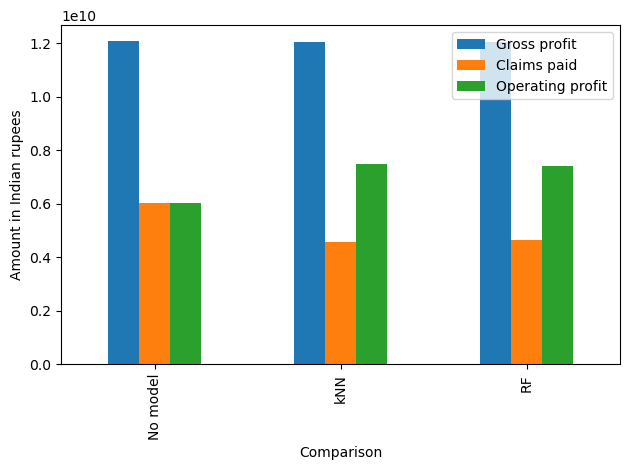

In [52]:
data = {"Comparison": ["No model", "kNN", "RF"], "Gross profit": [gross_profit, gross_profit-lossknn, gross_profit-lossrf],
        "Claims paid": [total_claim, total_claim-gainknn, total_claim-gainrf],
        "Operating profit": [gross_profit-total_claim, gross_profit-lossknn-(total_claim-gainknn), gross_profit-lossrf-(total_claim-gainrf)]}
chart = pd.DataFrame(data)
chart.plot(x='Comparison', kind='bar')
plt.ylabel('Amount in Indian rupees')
plt.tight_layout()

Due to the technical superiority of the kNN, it can also achieve the highest operating profit. Although some customers who submit a claim will be incorrectly flagged as fraudulent and thus lost and reduce the gross profit, this represents only 0.13% of the entire customer base. On the flip side, 24% of all claims made in a year can be avoided using the model, with an average claim costing 5x more than what a customer is charged. Due to this, even a model with a higher error rate than the desired 5% will be beneficial to the firm, over just paying out all claims. However, the impact of customer loss might be higher than simply losing their yearly charges and damage to the customer base or reputation in the long run should also be considered.

## 8. Conclusion (8 marks)

### a) What has been successfully accomplished and what has not been successful?

The final model was successful in providing a financially viable alternative to the client and there are not many reasons for not employing the model to the problem as described in the case study. The biggest shortcoming is that the desired error rate was not achieved. This could be due to many reasons related to both the model creation phase and the nature of the data, where it is in the best interest of a person committing fraud not to fall into obvious categories and thus such large accuracies might not even be feasible. The recommended model is thoroughly evaluated to give us confidence that it can generalise well to new data, which is the most important part when trying to predict fraud in the real world. Continuously tweaking the model to fit better to the final test data could actually result in overfitting it and defeat this purpose.

### b) Reflecting back on the analysis, what could you have done differently if you were to do the project again?

Pre-processing could definitely have been more thorough. With enough domain knowledge and testing, new features and feature spaces could have been extracted, and a different pre-processing pipeline fit for each model to provide them with the best possible data. This could include debating possible factors with domain experts. Hyperparameter optimisation could also have been more rigorous and a more powerful computational device should be used next time to be able to test more things in the limited time. This would also allow many different models to be tested, which could work better given enough time for fine-tuning. Using other tools such as RapidMiner for experimentation more could also prove fruitful.

### c) Provide a wish list of future work that you would like to do

The project could particularly be improved by using real accident data, such as damage photos, brake marks etc., which should all be standard measures when such accidents happen. Being able to implement a computer vision model to aid in fraud detection could be a very interesting exercise.